# NLP and Reddit Subcommunities - Modeling
---

In this notebook, our objective is to build models that can accurately classify the subreddit from which a given post originates. To achieve this, we will employ pipelines, grid-searching (GridSearchCV) and randomized-searching (RandomizedSearchCV), and iterating through different hyperparameters to evaluate the performance of various machine learning algorithms. Our focus will be on testing classification models such as Logistic Regression, Multinomial Naive Bayes, and Support Vector Machines. Additionally, we will address the challenges of overfitting or underfitting by considering approaches like Random Forest or Gradient Boosting, respectively. 

For more information on the data pulling and initial data cleaning, see the [initial notebook](./code/01_PRAW_Data_Acquisition_Initial_Cleaning.ipynb) of this analysis. For data exploration, further cleaning, and visualization, see the [second notebook](./02_EDA_and_Cleaning) of this analysis.

For more information on the background, a summary of methods, and findings, please see the associated [README](./README.md) for this analysis.

### Contents:
- [I. Baseline and Pre-Processing Functions](#I.-Baseline-and-Pre-Processing-Functions)
- [II. Model-Building and Testing](#II.-Model-Building-and-Testing)
    - [Pipelines and GridSearch / RandomizedSearch](#Pipelines-and-GridSearch-/-RandomizedSearch)
        - [Model 1: Logistic Regression](#Model-1:-Logistic-Regression)
        - [Model 2: Multinomial Naive Bayes](#Model-2:-Multinomial-Naive-Bayes)
        - [Model 3: Support Vector Machine](#Model-3:-Support-Vector-Machine)
    - [Ensembling](#Ensembling)
    - [Reducing Overfitting](#Reducing-Overfitting)
        - [Model 4: Random Forest and ExtraTrees](#Model-4:-Random-Forest-and-ExtraTrees)
- [III. Model Summarization](#II.-Model-Summarization)
- [IV. Final Model](#III.-Final-Model)
---

In [1]:
import warnings
warnings.filterwarnings('ignore') 
# Notebook was run with warnings enabled and any significant ones were addressed, remaining warnings are insignificant and 
 # have been suppressed

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, RocCurveDisplay, roc_auc_score
from sklearn.svm import LinearSVC, SVC
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier

In [3]:
snowski = pd.read_csv('../data/Clean/snow_ski2.csv')
snowski.head()

,created_utc,author,score,upvote_ratio,num_comments,subreddit,text,lem_text,stem_text,post_length,post_word_count
0,1.686844e+09,bas1cred,26,0.91,19,snowboardingnoobs,my first board. ready for the upcoming season!!,my first board ready for the upcoming season,my first board readi for the upcom season,48,8
1,1.686786e+09,Pooffios,3,1.00,12,snowboardingnoobs,"outer side foot pain hi all, i was hoping to g...",outer side foot pain hi all i wa hoping to get...,outer side foot pain hi all i wa hope to get s...,301,60
2,1.686781e+09,trips69420,2,0.75,15,snowboardingnoobs,first board? looking to probably grab this as ...,first board looking to probably grab this a my...,first board look to probabl grab thi as my fir...,274,53
3,1.686779e+09,twinbee,11,0.87,0,snowboardingnoobs,i did a front-side 180 today! more than one in...,i did a front side 180 today more than one in ...,i did a front side 180 today more than one in ...,1565,289
4,1.686767e+09,Madden_Stephen,2,0.67,24,snowboardingnoobs,step-on boot recommendation? i’ve done a decen...,step on boot recommendation i ve done a decent...,step on boot recommend i ve done a decent bit ...,686,122


---
## I. Baseline and Pre-Processing Functions
##### Please note: 
- ##### Lemmatizing and Stemming functions were generated and tested, but not all are used as final parameters in any of our models. The models were also run using "lem_text" and "stem_text" as target variables directly, but did not have any impact. 
- ##### A list of custom stop words was created to assist our model in identifying the subreddit from which a post originated (e.g., snowboard, snowboarding, ski, skiing). These custom words were tested as stop words in our models, but were ultimately excluded from further consideration. Introducing this additional complexity to our model is unnecessary and not aligned with our problem statement. The code for incorporating these custom stop words has been commented out below.
---

In [4]:
# Define baseline
snowski.subreddit.value_counts(normalize=True)

skiing               0.51242
snowboardingnoobs    0.48758
Name: subreddit, dtype: float64

##### <span style = 'color:blue'> Our model must have an accuracy score > 51.2% to be useful.</span>

In [5]:
snowski['subreddit'] = snowski['subreddit'].map({'snowboardingnoobs': 1, 'skiing': 0})

In [6]:
# Function for Lemmatizing
def lemmatize_txt(text):
    
    tokenizer = RegexpTokenizer('\w+')
    split_txt = tokenizer.tokenize(text)

    # Instantiate lemmatizer
    lemmatizer = WordNetLemmatizer()
        
    # Lemmatize and Rejoin
    return ' '.join([lemmatizer.lemmatize(word) for word in split_txt])

In [7]:
# Function for Stemming
def stem_txt(text):
    
    tokenizer = RegexpTokenizer('\w+')
    split_txt = tokenizer.tokenize(text)

    # Instantiate Stemmer
    p_stemmer = PorterStemmer()

    # Stem and Rejoin
    return ' '.join([p_stemmer.stem(word) for word in split_txt])

In [8]:
# Create and save custom stopwords

# english_stopwords = CountVectorizer(stop_words='english').get_stop_words() # source: https://scikit-learn-ts-git-feature-docs-2-saasify.vercel.app/docs/classes/CountVectorizer
# custom_words = ['snowboard', 'snowboarding', 'board', 'ski', 'skier', 'skiing', 'skis', 'just', 'like', 'wa', 'http', 'https', 'www', 'reddit', 'subreddit']
# custom_words = list(english_stopwords) + custom_words

In [9]:
X = snowski['text']
y = snowski['subreddit']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1527) 

---
## II. Model-Building and Testing
---

### Pipelines and GridSearch / RandomizedSearch

##### Please note that the parameter grids used for optimization contained more parameters than those shown below. To improve computational efficiency, only a selection of optimal parameters are included in the grids below, while others were excluded to minimize rerun time and avoid fitting unnecessary models.

#### Model 1: Logistic Regression

In [11]:
# Create pipeline that tests b/t CVEC and TVEC transformers and an estimator
pipe_log = Pipeline([
                 ('vec', None),
                 ('logr', LogisticRegression(solver = 'liblinear', max_iter=1000))])

In [12]:
# Define hyperparameters
pgrid_logr =[
    {
    'vec': [CountVectorizer()],
    'vec__stop_words': [None, 'english'],
    'vec__max_features': [7000, 8000], 
    'vec__min_df': [2, 3],
    'vec__max_df': [0.85], #tested 0.8, 0.95 as well
    #'vec__preprocessor': [None, lemmatize_txt, stem_txt],
    'logr__C': np.linspace(.05,10.0,10),
    'logr__penalty': ['l2'] #tested l1, l2 was more optimal
    },
    {
    'vec': [TfidfVectorizer()],
    'vec__stop_words': [None, 'english'],
    'vec__max_features': [7000, 8000], 
    'vec__min_df': [2, 3],
    'vec__max_df': [0.85],
    #'vec__preprocessor': [None, lemmatize_txt, stem_txt],
    'logr__C': np.linspace(.05,10.0,10),
    'logr__penalty': ['l2']
    }
]

In [13]:
%%time

# Fit model via GridSearch
gs_log = GridSearchCV(pipe_log, pgrid_logr, cv=5, n_jobs=10)
gs_log.fit(X_train, y_train)

CPU times: total: 2.47 s
Wall time: 27.9 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vec', None),
                                       ('logr',
                                        LogisticRegression(max_iter=1000,
                                                           solver='liblinear'))]),
             n_jobs=10,
             param_grid=[{'logr__C': array([ 0.05      ,  1.15555556,  2.26111111,  3.36666667,  4.47222222,
        5.57777778,  6.68333333,  7.78888889,  8.89444444, 10.        ]),
                          'logr__penalty': ['l2'], 'vec': [CountVectorizer()],
                          'vec__max_df': [0.85],
                          'vec__max_features':...
                          'vec__stop_words': [None, 'english']},
                         {'logr__C': array([ 0.05      ,  1.15555556,  2.26111111,  3.36666667,  4.47222222,
        5.57777778,  6.68333333,  7.78888889,  8.89444444, 10.        ]),
                          'logr__penalty': ['l2'],
                          'vec': [TfidfVectorizer(max_df=0.85,
                                                  max_features=7000, min_df=2,
                                                  stop_words='english')],
                          'vec__max_df': [0.85],
                          'vec__max_features': [7000, 8000],
                          'vec__min_df': [2, 3],
                          'vec__stop_words': [None, 'english']}])

In [14]:
# Make predictions for Accuracy Report
preds_log = gs_log.predict(X_test)

In [15]:
b1 = "\033[1m"
b0 = "\033[0m"

print(f'--------- {b1}Logistic Regression w/ GridSearch{b0} ---------') # source: https://stackoverflow.com/questions/8924173/how-can-i-print-bold-text-in-python
print(f'------------------- Train: {round(gs_log.score(X_train, y_train),4)} -------------------')
print(f'------------------- Test: {round(gs_log.score(X_test, y_test),4)} --------------------')
print('Best Params:', gs_log.best_params_)

--------- Logistic Regression w/ GridSearch ---------
------------------- Train: 0.9532 -------------------
------------------- Test: 0.8801 --------------------
Best Params: {'logr__C': 2.2611111111111106, 'logr__penalty': 'l2', 'vec': TfidfVectorizer(max_df=0.85, max_features=7000, min_df=2, stop_words='english'), 'vec__max_df': 0.85, 'vec__max_features': 7000, 'vec__min_df': 2, 'vec__stop_words': 'english'}


In [16]:
%%time

# The following optimized hyperparameters were observed during one of our RandomizedSearches, and are being applied here
pgrid_logr_best =[
    {
    'vec': [TfidfVectorizer()],
    'vec__stop_words': [None],
    'vec__max_features': [8000], 
    'vec__min_df': [2],
    'vec__max_df': [0.85],
    'logr__C': [5.577777777777777],
    'logr__penalty': ['l2']
    }
]

# Test RandomizedSearch for comparison in timing and outcome
rs_log = RandomizedSearchCV(pipe_log, pgrid_logr_best, cv=5, n_iter=10, n_jobs=10, random_state=111)
rs_log.fit(X_train, y_train)

CPU times: total: 93.8 ms
Wall time: 490 ms


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('vec', None),
                                             ('logr',
                                              LogisticRegression(max_iter=1000,
                                                                 solver='liblinear'))]),
                   n_jobs=10,
                   param_distributions=[{'logr__C': [5.577777777777777],
                                         'logr__penalty': ['l2'],
                                         'vec': [TfidfVectorizer(max_df=0.85,
                                                                 max_features=8000,
                                                                 min_df=2)],
                                         'vec__max_df': [0.85],
                                         'vec__max_features': [8000],
                                         'vec__min_df': [2],
                                         'vec__stop_words': [None]}],
                   random_state=111)

In [17]:
preds_log_r = rs_log.predict(X_test)

In [18]:
print(f'------ {b1}Logistic Regression w/ RandomizedSearch{b0} ------')
print(f'------------------- Train: {round(rs_log.score(X_train, y_train),4)} -------------------')
print(f'------------------- Test: {round(rs_log.score(X_test, y_test),4)} --------------------')
print('Best Params:', rs_log.best_params_)

# Randomized search computed faster and test score is slightly better - we will utilize RS more

------ Logistic Regression w/ RandomizedSearch ------
------------------- Train: 0.9728 -------------------
------------------- Test: 0.8836 --------------------
Best Params: {'vec__stop_words': None, 'vec__min_df': 2, 'vec__max_features': 8000, 'vec__max_df': 0.85, 'vec': TfidfVectorizer(max_df=0.85, max_features=8000, min_df=2), 'logr__penalty': 'l2', 'logr__C': 5.577777777777777}


In [19]:
# The code below was run with every rerun of this notebook and metrics were observed, commenting out to save computational power

#%%time 
# RandomizedSearch gives a slightly different testing score and parameters each run (when done without random_state), I want to see the average and SD over 30 runs to make sure random 
    # parameters chosen from single run are reprsentative
#num_runs = 35  # Number of runs
#results = []

#for i in range(num_runs):
    #rs_log = RandomizedSearchCV(pipe_log, pgrid_logr, cv=5, n_iter=10, n_jobs=10)
    #rs_log.fit(X_train, y_train)
    #results.append(rs_log.score(X_test, y_test))
    
#scr = sum(results) / len(results)
#scr_sd = (sum((i - scr)**2 for i in results) / len(results))**0.5
#lcl = scr - 1.96*scr_sd
#ucl = scr + 1.96*scr_sd

#print(f'MEAN: {round(scr,4)}')
#print(f'SD: {round(scr_sd,4)}')
#print(f'95% CI: ({round(lcl,4)}, {round(ucl,4)})')

MEAN: 0.8758
SD: 0.0049
95% CI: (0.8662, 0.8854)
CPU times: total: 8.33 s
Wall time: 1min 16s


In [79]:
# RandomSearch is not an exhaustive search within the predefined parameters grid, it randomly samples combinations,
    # providing a more efficient exploration of the hyperparameter space. Each run of RandomSearch will give a different
    # combination and therefore a slightly different training and testing accuracy score, sometimes even a better score than
    # when using GridSearch. We will choose whichever had the higher score between the two.
    
final_log_score = max(gs_log.score(X_test, y_test), rs_log.score(X_test, y_test))
if (gs_log.score(X_test, y_test)) > (rs_log.score(X_test, y_test)):
    final_log_preds = preds_log
else:
    final_log_preds = preds_log_r

---
#### Model 2: Multinomial Naive Bayes

In [20]:
pipe_nb = Pipeline([
    ('vec', None),
    ('nb', MultinomialNB())
])

In [21]:
pgrid_nb =[
    {
    'vec': [CountVectorizer()],
    'vec__stop_words': [None, 'english'],
    'vec__max_features': [7000, 8000], 
    'vec__min_df': [2, 3],
    'vec__max_df': [0.80, 0.90],
    #'vec__preprocessor': [None, lemmatize_txt, stem_txt],
    'nb__alpha': [.01, 0.5, 1.0, 5.0]
    },
    {
    'vec': [TfidfVectorizer()],
    'vec__stop_words': [None, 'english'],
    'vec__max_features': [7000, 8000], 
    'vec__min_df': [2, 3],
    'vec__max_df': [0.80, 0.90],
    #'vec__preprocessor': [None, lemmatize_txt, stem_txt],
    'nb__alpha': [.01, 0.5, 1.0, 5.0]
    }
]

In [22]:
%%time

gs_nb = GridSearchCV(pipe_nb, pgrid_nb, cv=5, n_jobs=5)
gs_nb.fit(X_train, y_train)

CPU times: total: 1.34 s
Wall time: 36.8 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vec', None), ('nb', MultinomialNB())]),
             n_jobs=5,
             param_grid=[{'nb__alpha': [0.01, 0.5, 1.0, 5.0],
                          'vec': [CountVectorizer()], 'vec__max_df': [0.8, 0.9],
                          'vec__max_features': [7000, 8000],
                          'vec__min_df': [2, 3],
                          'vec__stop_words': [None, 'english']},
                         {'nb__alpha': [0.01, 0.5, 1.0, 5.0],
                          'vec': [TfidfVectorizer(max_df=0.8, max_features=7000,
                                                  min_df=3,
                                                  stop_words='english')],
                          'vec__max_df': [0.8, 0.9],
                          'vec__max_features': [7000, 8000],
                          'vec__min_df': [2, 3],
                          'vec__stop_words': [None, 'english']}])

In [23]:
# Make predictions for Accuracy Report
preds_nb = gs_nb.predict(X_test)

In [24]:
print(f'---------- {b1}Multinomial Bayes w/ GridSearch{b0} ----------')
print(f'------------------- Train: {round(gs_nb.score(X_train, y_train),4)} -------------------')
print(f'------------------- Test: {round(gs_nb.score(X_test, y_test),4)} --------------------')
print('Best Params:', gs_nb.best_params_)

---------- Multinomial Bayes w/ GridSearch ----------
------------------- Train: 0.8905 -------------------
------------------- Test: 0.8566 --------------------
Best Params: {'nb__alpha': 5.0, 'vec': TfidfVectorizer(max_df=0.8, max_features=7000, min_df=3, stop_words='english'), 'vec__max_df': 0.8, 'vec__max_features': 7000, 'vec__min_df': 3, 'vec__stop_words': 'english'}


In [25]:
%%time

# Test RandomizedSearch for comparison in timing and outcome
rs_nb = RandomizedSearchCV(pipe_nb, pgrid_nb, cv=5, n_iter=10, n_jobs=5)
rs_nb.fit(X_train, y_train)

CPU times: total: 188 ms
Wall time: 2.81 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('vec', None),
                                             ('nb', MultinomialNB())]),
                   n_jobs=5,
                   param_distributions=[{'nb__alpha': [0.01, 0.5, 1.0, 5.0],
                                         'vec': [CountVectorizer(max_df=0.8,
                                                                 max_features=8000,
                                                                 min_df=3,
                                                                 stop_words='english')],
                                         'vec__max_df': [0.8, 0.9],
                                         'vec__max_features': [7000, 8000],
                                         'vec__min_df': [2, 3],
                                         'vec__stop_words': [None, 'english']},
                                        {'nb__alpha': [0.01, 0.5, 1.0, 5.0],
                                         'vec': [TfidfVectorizer(max_df=0.8,
                                                                 max_features=7000,
                                                                 min_df=3,
                                                                 stop_words='english')],
                                         'vec__max_df': [0.8, 0.9],
                                         'vec__max_features': [7000, 8000],
                                         'vec__min_df': [2, 3],
                                         'vec__stop_words': [None, 'english']}])

In [26]:
preds_nb_r = rs_nb.predict(X_test)

In [27]:
print(f'------- {b1}Multinomial Bayes w/ RandomizedSearch{b0} -------')
print(f'------------------- Train: {round(rs_nb.score(X_train, y_train),4)} -------------------')
print(f'------------------- Test: {round(rs_nb.score(X_test, y_test),4)} --------------------')
print('Best Params:', rs_nb.best_params_)

# Randomized search computed faster and test score is slightly better - we will utilize RS more

------- Multinomial Bayes w/ RandomizedSearch -------
------------------- Train: 0.8808 -------------------
------------------- Test: 0.8637 --------------------
Best Params: {'vec__stop_words': 'english', 'vec__min_df': 3, 'vec__max_features': 8000, 'vec__max_df': 0.8, 'vec': CountVectorizer(max_df=0.8, max_features=8000, min_df=3, stop_words='english'), 'nb__alpha': 5.0}


In [28]:
#%%time 
#RandomizedSearch gives a slightly different testing score and parameters each run (when done without random_state), I want to see the average and SD over 30 runs to make sure random 
    # parameters chosen from single run are reprsentative
#num_runs = 35  # Number of runs
#results = []

#for i in range(num_runs):
    #rs_nb = RandomizedSearchCV(pipe_nb, pgrid_nb, cv=5, n_iter=10, n_jobs=10)
    #rs_nb.fit(X_train, y_train)
    #results.append(rs_nb.score(X_test, y_test))
    
#scr = sum(results) / len(results)
#scr_sd = (sum((i - scr)**2 for i in results) / len(results))**0.5
#lcl = scr - 1.96*scr_sd
#ucl = scr + 1.96*scr_sd

#print(f'MEAN: {round(scr,4)}')
#print(f'SD: {round(scr_sd,4)}')
#print(f'95% CI: ({round(lcl,4)}, {round(ucl,4)})')

In [ ]:
# RandomSearch is not an exhaustive search within the predefined parameters grid, it randomly samples combinations,
    # providing a more efficient exploration of the hyperparameter space. Each run of RandomSearch will give a different
    # combination and therefore a slightly different training and testing accuracy score, sometimes even a better score than
    # when using GridSearch. We will choose whichever had the higher score between the two.
    
final_nb_score = max(gs_nb.score(X_test, y_test), rs_nb.score(X_test, y_test))
if (gs_nb.score(X_test, y_test)) > (rs_nb.score(X_test, y_test)):
    final_nb_preds = preds_nb
else:
    final_nb_preds = preds_nb_r

---
#### Model 3: Support Vector Machine

In [29]:
pipe_svc = Pipeline([
    ('vec', None),
    ('svc', SVC())
])

In [30]:
pgrid_svc =[
    {
     'vec': [CountVectorizer()],
     'vec__stop_words': [None], #tested english stopwords as well
     'vec__max_features': [7000], #also tested 8000 
     'vec__min_df': [3, 5],
     'vec__max_df': [0.80], #tested 0.90 as well
     'svc__C': np.linspace(0.0001, 2, 10),
     #'svc__kernel': ['rbf','poly'],
     'svc__degree' : [2]
    },
    {
     'vec': [TfidfVectorizer()],
     'vec__stop_words': [None],
     'vec__max_features': [7000], 
     'vec__min_df': [3, 5],
     'vec__max_df': [0.80],
     'svc__C': np.linspace(0.0001, 2, 10),
     #'svc__kernel': ['rbf','poly'],
     'svc__degree' : [2]
    }
]

In [31]:
%%time

gs_svc = GridSearchCV(pipe_svc, pgrid_svc, n_jobs=25)
gs_svc.fit(X_train, y_train)

CPU times: total: 3.77 s
Wall time: 2min 3s


GridSearchCV(estimator=Pipeline(steps=[('vec', None), ('svc', SVC())]),
             n_jobs=25,
             param_grid=[{'svc__C': array([1.00000000e-04, 2.22311111e-01, 4.44522222e-01, 6.66733333e-01,
       8.88944444e-01, 1.11115556e+00, 1.33336667e+00, 1.55557778e+00,
       1.77778889e+00, 2.00000000e+00]),
                          'svc__degree': [2], 'vec': [CountVectorizer()],
                          'vec__max_df': [0.8], 'vec__max_features': [7000],
                          'vec__min_df': [3, 5], 'vec__stop_words': [None]},
                         {'svc__C': array([1.00000000e-04, 2.22311111e-01, 4.44522222e-01, 6.66733333e-01,
       8.88944444e-01, 1.11115556e+00, 1.33336667e+00, 1.55557778e+00,
       1.77778889e+00, 2.00000000e+00]),
                          'svc__degree': [2],
                          'vec': [TfidfVectorizer(max_df=0.8, max_features=7000,
                                                  min_df=3)],
                          'vec__max_df': [0.8], 'vec__max_features': [7000],
                          'vec__min_df': [3, 5], 'vec__stop_words': [None]}])

In [32]:
# Make predictions for Accuracy Report
preds_svc = gs_svc.predict(X_test)

In [33]:
print(f'----------------- {b1}SVM w/ GridSearch{b0} ----------------')
print(f'------------------ Train: {round(gs_svc.score(X_train, y_train),4)} -------------------')
print(f'------------------- Test: {round(gs_svc.score(X_test, y_test),4)} -------------------')
print('Best Params:', gs_svc.best_params_)

----------------- SVM w/ GridSearch ----------------
------------------ Train: 0.9979 -------------------
------------------- Test: 0.8829 -------------------
Best Params: {'svc__C': 1.7777888888888889, 'svc__degree': 2, 'vec': TfidfVectorizer(max_df=0.8, max_features=7000, min_df=3), 'vec__max_df': 0.8, 'vec__max_features': 7000, 'vec__min_df': 3, 'vec__stop_words': None}


In [34]:
%%time

# Test RandomizedSearch for comparison in timing and outcome
rs_svc = RandomizedSearchCV(pipe_svc, pgrid_svc, cv=5, n_iter=10, n_jobs=15)
rs_svc.fit(X_train, y_train)

CPU times: total: 2.59 s
Wall time: 29.2 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('vec', None), ('svc', SVC())]),
                   n_jobs=15,
                   param_distributions=[{'svc__C': array([1.00000000e-04, 2.22311111e-01, 4.44522222e-01, 6.66733333e-01,
       8.88944444e-01, 1.11115556e+00, 1.33336667e+00, 1.55557778e+00,
       1.77778889e+00, 2.00000000e+00]),
                                         'svc__degree': [2],
                                         'vec': [CountVectorizer()],
                                         'vec__max_df': [0.8],
                                         'vec__m...
                                         'vec__stop_words': [None]},
                                        {'svc__C': array([1.00000000e-04, 2.22311111e-01, 4.44522222e-01, 6.66733333e-01,
       8.88944444e-01, 1.11115556e+00, 1.33336667e+00, 1.55557778e+00,
       1.77778889e+00, 2.00000000e+00]),
                                         'svc__degree': [2],
                                         'vec': [TfidfVectorizer(max_df=0.8,
                                                                 max_features=7000,
                                                                 min_df=5)],
                                         'vec__max_df': [0.8],
                                         'vec__max_features': [7000],
                                         'vec__min_df': [3, 5],
                                         'vec__stop_words': [None]}])

In [35]:
# Make predictions for Accuracy Report
preds_svc_r = rs_svc.predict(X_test)

In [36]:
print(f'-------------- {b1}SVM w/ RandomizedSearch{b0} --------------')
print(f'------------------- Train: {round(rs_svc.score(X_train, y_train),4)} -------------------')
print(f'------------------- Test: {round(rs_svc.score(X_test, y_test),4)} --------------------')
print('Best Params:', rs_svc.best_params_)

# Randomized search computed faster and test score is slightly better - we will utilize RS more

-------------- SVM w/ RandomizedSearch --------------
------------------- Train: 0.9955 -------------------
------------------- Test: 0.8751 --------------------
Best Params: {'vec__stop_words': None, 'vec__min_df': 5, 'vec__max_features': 7000, 'vec__max_df': 0.8, 'vec': TfidfVectorizer(max_df=0.8, max_features=7000, min_df=5), 'svc__degree': 2, 'svc__C': 1.5555777777777777}


In [37]:
#%%time 
#RandomizedSearch gives a slightly different testing score and parameters each run (when done without random_state), I want to see the average and SD over 30 runs to make sure random 
    # parameters chosen from single run are reprsentative
#num_runs = 35  # Number of runs
#results = []

#for i in range(num_runs):
    #rs_svc = RandomizedSearchCV(pipe_svc, pgrid_svc, cv=5, n_iter=10, n_jobs=15)
    #rs_svc.fit(X_train, y_train)
    #results.append(rs_svc.score(X_test, y_test))
    
#scr = sum(results) / len(results)
#scr_sd = (sum((i - scr)**2 for i in results) / len(results))**0.5
#lcl = scr - 1.96*scr_sd
#ucl = scr + 1.96*scr_sd

#print(f'MEAN: {round(scr,4)}')
#print(f'SD: {round(scr_sd,4)}')
#print(f'95% CI: ({round(lcl,4)}, {round(ucl,4)})')

In [ ]:
# RandomSearch is not an exhaustive search within the predefined parameters grid, it randomly samples combinations,
    # providing a more efficient exploration of the hyperparameter space. Each run of RandomSearch will give a different
    # combination and therefore a slightly different training and testing accuracy score, sometimes even a better score than
    # when using GridSearch. We will choose whichever had the higher score between the two.
    
final_svc_score = max(gs_svc.score(X_test, y_test), rs_svc.score(X_test, y_test))
if (gs_svc.score(X_test, y_test)) > (rs_svc.score(X_test, y_test)):
    final_svc_preds = preds_svc
else:
    final_svc_preds = preds_svc_r

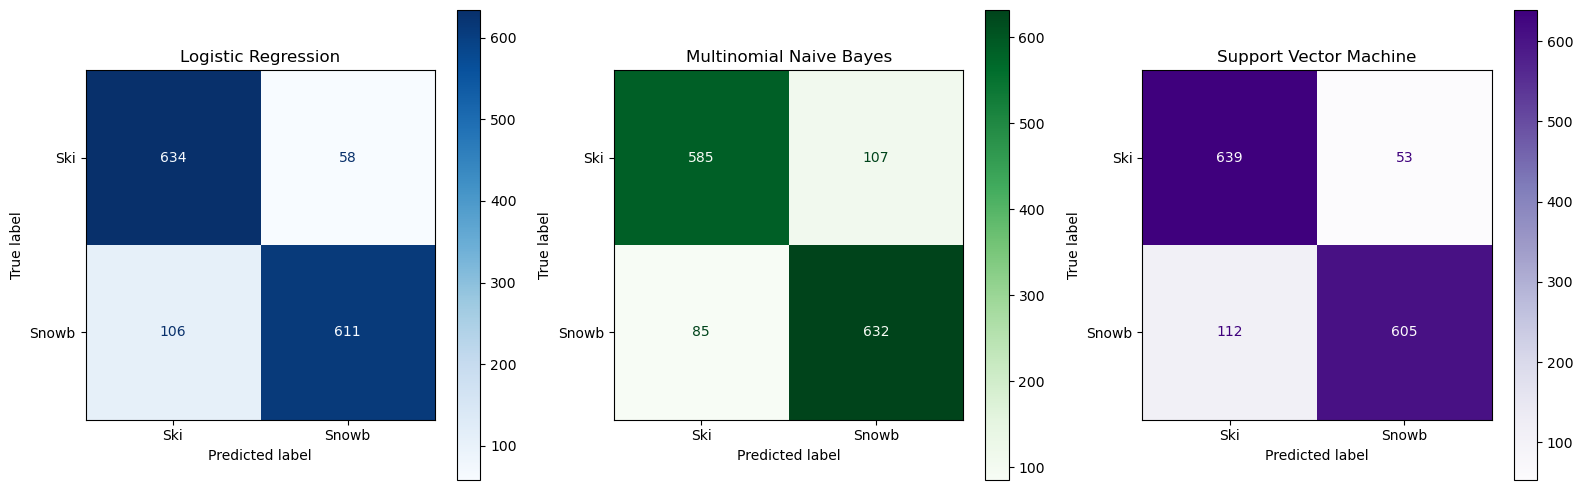

In [38]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

if (gs_log.score(X_test, y_test)) > (rs_log.score(X_test, y_test)):
    final_log = 
final_log_preds = max(preds_log, preds_log_r)
final_nb_preds = max(preds_nb, preds_nb_r)
final_svc_preds = max(preds_svc, preds_svc_r)

ConfusionMatrixDisplay.from_predictions(y_test, final_log_preds, display_labels = ['Ski', 'Snowb'], cmap = 'Blues', ax=ax[0]);
ConfusionMatrixDisplay.from_predictions(y_test, final_nb_preds, display_labels = ['Ski', 'Snowb'], cmap = 'Greens', ax=ax[1]);
ConfusionMatrixDisplay.from_predictions(y_test, final_svc_preds, display_labels = ['Ski', 'Snowb'], cmap = 'Purples', ax=ax[2]);

plt.tight_layout()
ax[0].set_title('Logistic Regression')
ax[1].set_title('Multinomial Naive Bayes')
ax[2].set_title('Support Vector Machine');

In [39]:
print(f'\n---------------------- {b1}Logistic{b0} ---------------------- \n {classification_report(y_test, final_log_preds, digits=4)} \n')
print(f'------------------------- {b1}NB{b0} ------------------------- \n  {classification_report(y_test, final_nb_preds, digits=4)} \n')
print(f'------------------------- {b1}SVM{b0} ------------------------- \n  {classification_report(y_test, final_svc_preds, digits=4)}')


---------------------- Logistic ---------------------- 
               precision    recall  f1-score   support

           0     0.8568    0.9162    0.8855       692
           1     0.9133    0.8522    0.8817       717

    accuracy                         0.8836      1409
   macro avg     0.8850    0.8842    0.8836      1409
weighted avg     0.8855    0.8836    0.8835      1409
 

------------------------- NB ------------------------- 
                precision    recall  f1-score   support

           0     0.8731    0.8454    0.8590       692
           1     0.8552    0.8815    0.8681       717

    accuracy                         0.8637      1409
   macro avg     0.8642    0.8634    0.8636      1409
weighted avg     0.8640    0.8637    0.8637      1409
 

------------------------- SVM ------------------------- 
                precision    recall  f1-score   support

           0     0.8509    0.9234    0.8857       692
           1     0.9195    0.8438    0.8800       717

   

##### <span style = 'color: blue'> <u>**Outcomes and Comparison**</u>: </span>

- <span style = 'color: blue'>The **Logistic Regression** model best parameters included:</span>
    - <span style = 'color: blue'>TfidfVectorizer</span>
        - <span style = 'color: blue'>max_df=0.85</span>
        - <span style = 'color: blue'>max_features=8000</span>
        - <span style = 'color: blue'>min_df=2</span>
        - <span style = 'color: blue'>stop_words=None </span>
    - <span style = 'color: blue'>'logr__C': 5.5778</span>
    - <span style = 'color: blue'>'logr__penalty': 'l2'</span>
    <br></br>

- <span style = 'color: blue'>The **Multinomial Bayes** model best parameters included:</span>
     - <span style = 'color: blue'>TfidfVectorizer
        - max_df=0.8
        - max_features=7000
        - min_df=3
        - stop_words='english'
    - <span style = 'color: blue'>'nb__alpha': 5.0
    <br></br>
        
- <span style = 'color: blue'>The **Support Vector Machine** model best parameters included:</span>
    - <span style = 'color: blue'>TfidfVectorizer</span>
        - <span style = 'color: blue'>max_df=0.8</span>
        - <span style = 'color: blue'>max_features=7000</span>
        - <span style = 'color: blue'>min_df=3
        - <span style = 'color: blue'>stop_words': None</span>
    - <span style = 'color: blue'>'svc__C': 1.7778 </span>
    - <span style = 'color: blue'>'svc__degree': 2 </span>      <br></br>
- <span style = 'color: blue'>The **Logistic Regression (LR)** and **Support Vector Machine (SVM)** had similar performances, and both performed better than Multinomial Naive Bayes (MNB).</span>
    - <span style = 'color: blue'>The LR had ...
        - A higher testing **accuracy** score than both SVM and MNB (LR: 88.4% vs. SVM: 88.3% and MNB: 85.7%) 
        - A **precision** of 91.3% (compared to SVM: 92.0% and MNB: 83.8%)
        - A **sensitivity** of 85.2% (compared to SVM: 84.4% and MNB: 89.0%)
        - A **specificity** of 91.6% (compared to SVM: 92.3% and MNB: 82.2%)


---
### Ensembling
##### Here we will test if Ensembling Models 1-3 makes a better model, by how much, and any other considerations. 

In [40]:
vc = VotingClassifier([
    ('logr_e', rs_log), 
    ('nb_e', rs_nb),
    ('svc_e', gs_svc)
])

In [41]:
%%time
vc.fit(X_train, y_train)

CPU times: total: 4.67 s
Wall time: 1min 44s


VotingClassifier(estimators=[('logr_e',
                              RandomizedSearchCV(cv=5,
                                                 estimator=Pipeline(steps=[('vec',
                                                                            None),
                                                                           ('logr',
                                                                            LogisticRegression(max_iter=1000,
                                                                                               solver='liblinear'))]),
                                                 n_jobs=10,
                                                 param_distributions=[{'logr__C': array([ 0.05      ,  1.15555556,  2.26111111,  3.36666667,  4.47222222,
        5.57777778,  6.68333333,  7.78888889,  8.89444444, 10.        ]),
                                                                       'logr__penalty': ['l2'],
                                                                       'vec': [CountV...
                                                        'vec__stop_words': [None]},
                                                       {'svc__C': array([1.00000000e-04, 2.22311111e-01, 4.44522222e-01, 6.66733333e-01,
       8.88944444e-01, 1.11115556e+00, 1.33336667e+00, 1.55557778e+00,
       1.77778889e+00, 2.00000000e+00]),
                                                        'svc__degree': [2],
                                                        'vec': [TfidfVectorizer(max_df=0.8,
                                                                                max_features=7000,
                                                                                min_df=5)],
                                                        'vec__max_df': [0.8],
                                                        'vec__max_features': [7000],
                                                        'vec__min_df': [3, 5],
                                                        'vec__stop_words': [None]}]))])

In [42]:
print(f'----------------- {b1}Ensembling Scores{b0} -----------------')
print(f'------------------- Train: {round(vc.score(X_train, y_train),4)} -------------------')
print(f'-------------------- Test: {round(vc.score(X_test, y_test),4)} -------------------')

----------------- Ensembling Scores -----------------
------------------- Train: 0.96 -------------------
-------------------- Test: 0.8815 -------------------


##### <span style = 'color:blue'> Ensembling all three models we built did not improve testing accuracy, therefore we will not proceed with this approach as the gain is insufficient. We instead turn our attention to attempting to reduce any overfitting.</span>

---
### Reducing Overfitting


#### Model 4: Random Forest and ExtraTrees
##### This model will be attempting to address overfitting. All three models that have been fit have higher training scores than testing scores by ~4-10%:
- Logistic Regression
    - Train = 0.9728
    - Test: 0.8836   
- Multinomial Naive Bayes
    - Train = 0.9025
    - Test = 0.8595
- Support Vector Machine
    - Train = 0.9875
    - Test = 0.8772
    
##### We will test Random Forest Classifier and Extra Trees to see if either ameliorates this impact and improves our model.

##### Random Forest

In [43]:
# RANDOM FOREST
pipe_rf = Pipeline([
    ('vec', None),
    ('rf', RandomForestClassifier())
])

In [44]:
pgrid_rf =[
    {
    'vec': [CountVectorizer()],
    'vec__stop_words': [None], #tested english as well
    'vec__max_features': [7000], #tested 8000 as well
    'vec__min_df': [3, 5],
    'vec__max_df': [0.80],
    'rf__n_estimators': [300, 350],
    'rf__max_depth': [50]
    },
    {
    'vec': [TfidfVectorizer()],
    'vec__stop_words': [None],
    'vec__max_features': [7000], 
    'vec__min_df': [3, 5],
    'vec__max_df': [0.80],
    'rf__n_estimators': [300, 350],
    'rf__max_depth': [50]
    }
]

In [45]:
%%time

gs_rf = GridSearchCV(pipe_rf, pgrid_rf, cv=5, n_jobs=25)
gs_rf.fit(X_train, y_train)

CPU times: total: 8.28 s
Wall time: 1min 6s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vec', None),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=25,
             param_grid=[{'rf__max_depth': [50], 'rf__n_estimators': [300, 350],
                          'vec': [CountVectorizer(max_df=0.8, max_features=7000,
                                                  min_df=5)],
                          'vec__max_df': [0.8], 'vec__max_features': [7000],
                          'vec__min_df': [3, 5], 'vec__stop_words': [None]},
                         {'rf__max_depth': [50], 'rf__n_estimators': [300, 350],
                          'vec': [TfidfVectorizer()], 'vec__max_df': [0.8],
                          'vec__max_features': [7000], 'vec__min_df': [3, 5],
                          'vec__stop_words': [None]}])

In [46]:
# Make predictions for Accuracy Report
preds_rf = gs_rf.predict(X_test)

In [47]:
print(f'------------- {b1}Random Forest w/ GridSearch{b0} ------------')
print(f'------------------- Train: {round(gs_rf.score(X_train, y_train),4)} --------------------')
print(f'------------------- Test: {round(gs_rf.score(X_test, y_test),4)} ---------------------')
print('Best Params:', gs_rf.best_params_)

------------- Random Forest w/ GridSearch ------------
------------------- Train: 0.9529 --------------------
------------------- Test: 0.8495 ---------------------
Best Params: {'rf__max_depth': 50, 'rf__n_estimators': 350, 'vec': CountVectorizer(max_df=0.8, max_features=7000, min_df=5), 'vec__max_df': 0.8, 'vec__max_features': 7000, 'vec__min_df': 5, 'vec__stop_words': None}


In [48]:
%%time

rs_rf = RandomizedSearchCV(pipe_rf, pgrid_rf, cv=5, n_iter = 10, n_jobs=25)
rs_rf.fit(X_train, y_train)

CPU times: total: 7.7 s
Wall time: 1min 12s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('vec', None),
                                             ('rf', RandomForestClassifier())]),
                   n_jobs=25,
                   param_distributions=[{'rf__max_depth': [50],
                                         'rf__n_estimators': [300, 350],
                                         'vec': [CountVectorizer(max_df=0.8,
                                                                 max_features=7000,
                                                                 min_df=5)],
                                         'vec__max_df': [0.8],
                                         'vec__max_features': [7000],
                                         'vec__min_df': [3, 5],
                                         'vec__stop_words': [None]},
                                        {'rf__max_depth': [50],
                                         'rf__n_estimators': [300, 350],
                                         'vec': [TfidfVectorizer()],
                                         'vec__max_df': [0.8],
                                         'vec__max_features': [7000],
                                         'vec__min_df': [3, 5],
                                         'vec__stop_words': [None]}])

In [49]:
# Make predictions for Accuracy Report
preds_rf_r = rs_rf.predict(X_test)

In [50]:
print(f'--------- {b1}Random Forest w/ RandomizedSearch{b0} ---------')
print(f'-------------------- Train: {round(rs_rf.score(X_train, y_train),4)} ------------------')
print(f'-------------------- Test: {round(rs_rf.score(X_test, y_test),4)} -------------------')
print('Best Params:', rs_rf.best_params_)

--------- Random Forest w/ RandomizedSearch ---------
-------------------- Train: 0.952 ------------------
-------------------- Test: 0.8474 -------------------
Best Params: {'vec__stop_words': None, 'vec__min_df': 5, 'vec__max_features': 7000, 'vec__max_df': 0.8, 'vec': CountVectorizer(max_df=0.8, max_features=7000, min_df=5), 'rf__n_estimators': 350, 'rf__max_depth': 50}


In [88]:
# RandomSearch is not an exhaustive search within the predefined parameters grid, it randomly samples combinations,
    # providing a more efficient exploration of the hyperparameter space. Each run of RandomSearch will give a different
    # combination and therefore a slightly different training and testing accuracy score, sometimes even a better score than
    # when using GridSearch. We will choose whichever had the higher score between the two.
    
final_rf_score = max(gs_rf.score(X_test, y_test), rs_rf.score(X_test, y_test))
if (gs_rf.score(X_test, y_test)) > (rs_rf.score(X_test, y_test)):
    final_rf_preds = preds_rf
    final_rf = gs_rf
else:
    final_rf_preds = preds_rf_r
    final_rf = rs_rf

In [84]:
final_rf.best_score_

0.8585281239945726

In [52]:
final_rf.best_estimator_.named_steps['rf']

RandomForestClassifier(max_depth=50, n_estimators=350)

In [53]:
# source: https://github.com/scikit-learn/scikit-learn/issues/21349, ChatGPT
best_estimator = final_rf.best_estimator_
random_forest = best_estimator.named_steps['rf']
feature_importances = random_forest.feature_importances_

vec = best_estimator.named_steps['vec']
if isinstance(vec, CountVectorizer):
    feature_names = vec.get_feature_names_out()
elif isinstance(vec, TfidfVectorizer):
    feature_names = vec.transformer_.get_feature_names_out()

print(feature_names)
print(feature_importances)

['000' '04' '10' ... 'youtube' 'zero' 'zone']
[2.42657187e-05 1.81103775e-04 8.12476727e-04 ... 3.22013820e-04
 4.60665943e-05 3.74173362e-05]


In [54]:
# Make df
df = pd.DataFrame({'feature_names':feature_names,
                   'feature_importance': feature_importances})

#Sort by creasing feature importance
df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
df2 = df.reset_index().drop(columns = ['index']).head(30)

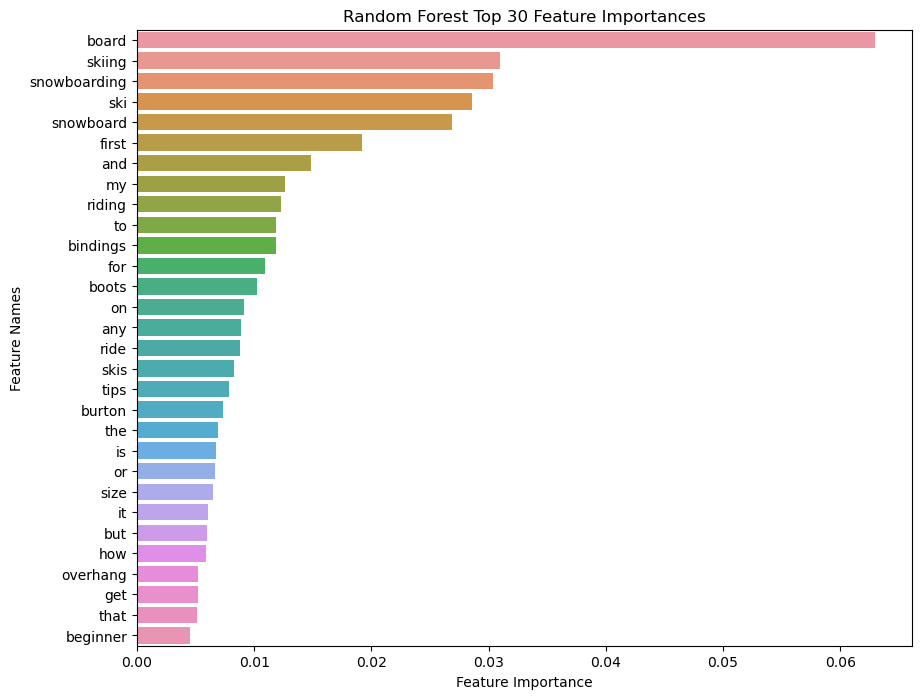

In [55]:
#Sort the DataFrame by descending
plt.figure(figsize=(10,8))
sns.barplot(x=df2['feature_importance'], y=df2['feature_names'])
plt.title('Random Forest Top 30 Feature Importances')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names');

##### Extra Trees

In [56]:
# EXTRA TREES
pipe_et = Pipeline([
    ('vec', None),
    ('et', ExtraTreesClassifier())
])

In [57]:
pgrid_et =[
    {
    'vec': [CountVectorizer()],
    'vec__stop_words': ['english'], #tested None as well
    'vec__max_features': [7000], #tested 8000 as well
    'vec__min_df': [3, 5],
    'vec__max_df': [0.80],
    'et__n_estimators': [300, 350],
    'et__max_depth': [50]
    },
    {
    'vec': [TfidfVectorizer()],
    'vec__stop_words': ['english'],
    'vec__max_features': [7000], 
    'vec__min_df': [3, 5],
    'vec__max_df': [0.80],
    'et__n_estimators': [300, 350],
    'et__max_depth': [50]
    }
]

In [58]:
%%time

gs_et = GridSearchCV(pipe_et, pgrid_et, cv=5, n_jobs=25)
gs_et.fit(X_train, y_train)

CPU times: total: 5.97 s
Wall time: 49.7 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vec', None),
                                       ('et', ExtraTreesClassifier())]),
             n_jobs=25,
             param_grid=[{'et__max_depth': [50], 'et__n_estimators': [300, 350],
                          'vec': [CountVectorizer()], 'vec__max_df': [0.8],
                          'vec__max_features': [7000], 'vec__min_df': [3, 5],
                          'vec__stop_words': ['english']},
                         {'et__max_depth': [50], 'et__n_estimators': [300, 350],
                          'vec': [TfidfVectorizer(max_df=0.8, max_features=7000,
                                                  min_df=5,
                                                  stop_words='english')],
                          'vec__max_df': [0.8], 'vec__max_features': [7000],
                          'vec__min_df': [3, 5],
                          'vec__stop_words': ['english']}])

In [59]:
# Make predictions for Accuracy Report
preds_et = gs_et.predict(X_test)

In [60]:
print(f'------------- {b1}Extra Trees w/ GridSearch{b0} -------------')
print(f'------------------- Train: {round(gs_et.score(X_train, y_train),4)} -------------------')
print(f'------------------- Test: {round(gs_et.score(X_test, y_test),4)} --------------------')
print('Best Params:', gs_et.best_params_)

------------- Extra Trees w/ GridSearch -------------
------------------- Train: 0.9196 -------------------
------------------- Test: 0.8432 --------------------
Best Params: {'et__max_depth': 50, 'et__n_estimators': 350, 'vec': TfidfVectorizer(max_df=0.8, max_features=7000, min_df=5, stop_words='english'), 'vec__max_df': 0.8, 'vec__max_features': 7000, 'vec__min_df': 5, 'vec__stop_words': 'english'}


In [61]:
gs_et.best_score_

0.8502494159777303

In [62]:
%%time

rs_et = RandomizedSearchCV(pipe_et, pgrid_et, cv=5, n_iter = 10, n_jobs=25)
rs_et.fit(X_train, y_train)

CPU times: total: 5.08 s
Wall time: 48.2 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('vec', None),
                                             ('et', ExtraTreesClassifier())]),
                   n_jobs=25,
                   param_distributions=[{'et__max_depth': [50],
                                         'et__n_estimators': [300, 350],
                                         'vec': [CountVectorizer()],
                                         'vec__max_df': [0.8],
                                         'vec__max_features': [7000],
                                         'vec__min_df': [3, 5],
                                         'vec__stop_words': ['english']},
                                        {'et__max_depth': [50],
                                         'et__n_estimators': [300, 350],
                                         'vec': [TfidfVectorizer(max_df=0.8,
                                                                 max_features=7000,
                                                                 min_df=5,
                                                                 stop_words='english')],
                                         'vec__max_df': [0.8],
                                         'vec__max_features': [7000],
                                         'vec__min_df': [3, 5],
                                         'vec__stop_words': ['english']}])

In [63]:
# Make predictions for Accuracy Report
preds_et_r = rs_et.predict(X_test)

In [64]:
print(f'---------- {b1}Extra Trees w/ RandomizedSearch{b0} ----------')
print(f'------------------- Train: {round(rs_et.score(X_train, y_train),4)} -------------------')
print(f'------------------- Test: {round(rs_et.score(X_test, y_test),4)} --------------------')
print('Best Params:', rs_et.best_params_)

---------- Extra Trees w/ RandomizedSearch ----------
------------------- Train: 0.9196 -------------------
------------------- Test: 0.8417 --------------------
Best Params: {'vec__stop_words': 'english', 'vec__min_df': 5, 'vec__max_features': 7000, 'vec__max_df': 0.8, 'vec': TfidfVectorizer(max_df=0.8, max_features=7000, min_df=5, stop_words='english'), 'et__n_estimators': 300, 'et__max_depth': 50}


In [86]:
# RandomSearch is not an exhaustive search within the predefined parameters grid, it randomly samples combinations,
    # providing a more efficient exploration of the hyperparameter space. Each run of RandomSearch will give a different
    # combination and therefore a slightly different training and testing accuracy score, sometimes even a better score than
    # when using GridSearch. We will choose whichever had the higher score between the two.
    
final_et_score = max(gs_et.score(X_test, y_test), rs_et.score(X_test, y_test))
if (gs_et.score(X_test, y_test)) > (rs_et.score(X_test, y_test)):
    final_et_preds = preds_et
    final_et = gs_et
else:
    final_et_preds = preds_et_r
    final_et = rs_et

In [87]:
final_et.best_score_

0.8502494159777303

In [66]:
final_et.best_estimator_.named_steps['et']

ExtraTreesClassifier(max_depth=50, n_estimators=300)

In [67]:
# source: https://github.com/scikit-learn/scikit-learn/issues/21349, ChatGPT
best_estimator = final_et.best_estimator_
random_forest = best_estimator.named_steps['et']
feature_importances = random_forest.feature_importances_

vec = best_estimator.named_steps['vec']
if isinstance(vec, CountVectorizer):
    feature_names = vec.get_feature_names_out()
elif isinstance(vec, TfidfVectorizer):
    feature_names = vec.transformer_.get_feature_names_out()

print(feature_names)
print(feature_importances)

['000' '04' '10' ... 'youtube' 'zero' 'zone']
[1.26781979e-05 2.52860523e-04 6.73520007e-04 ... 2.59411832e-04
 7.11606371e-05 5.59833853e-05]


In [68]:
# Make df
df = pd.DataFrame({'feature_names':feature_names,
                   'feature_importance': feature_importances})

#Sort by creasing feature importance
df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
df2 = df.reset_index().drop(columns = ['index']).head(30)

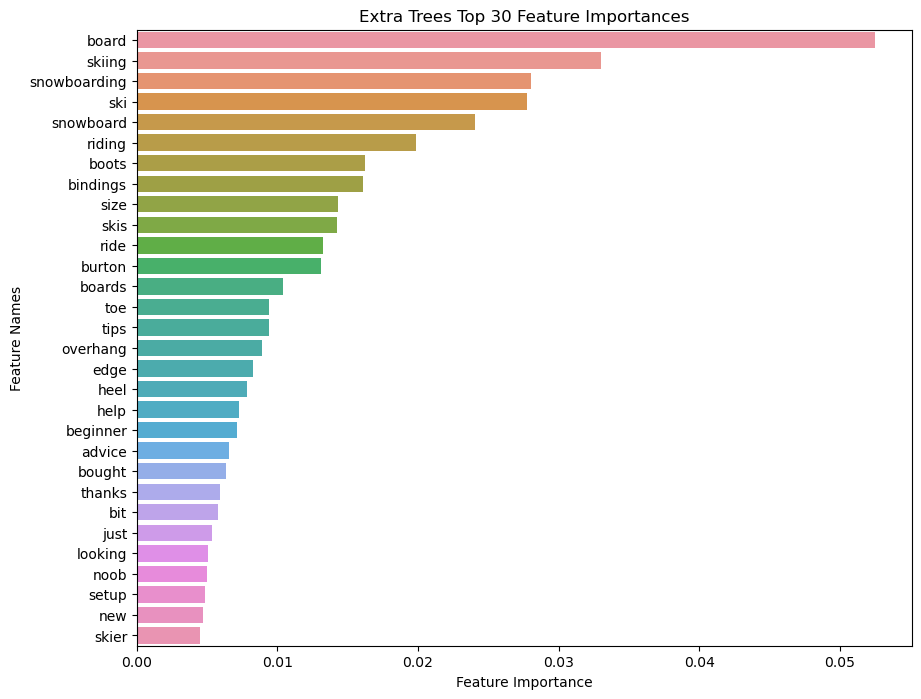

In [69]:
#Sort the DataFrame by descending
plt.figure(figsize=(10,8))
sns.barplot(x=df2['feature_importance'], y=df2['feature_names'])
plt.title('Extra Trees Top 30 Feature Importances')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names');

In [91]:
print(f'---------------- {b1}Random Forest Final{b0} ----------------')
print(f'------------------- Train: {round(final_rf.score(X_train, y_train),4)} -------------------')
print(f'------------------- Test: {round(final_rf.score(X_test, y_test),4)} --------------------\n')

print(f'----------------- {b1}Extra Trees Final{b0} -----------------')
print(f'------------------- Train: {round(final_et.score(X_train, y_train),4)} -------------------')
print(f'------------------- Test: {round(final_et.score(X_test, y_test),4)} --------------------')

---------------- Random Forest Final ----------------
------------------- Train: 0.9529 -------------------
------------------- Test: 0.8495 --------------------

----------------- Extra Trees Final -----------------
------------------- Train: 0.9196 -------------------
------------------- Test: 0.8432 --------------------


### III. Model Summarization

In [78]:
# Taking the best model between the Gridsearches and Randomizedsearches
summ = [final_log_score,
        final_nb_score, 
        final_svc_score), 
        vc.score(X_test, y_test),
        final_rf_score, 
        final_et_score]
mod = ['Logistic Regression', 'Multinomial Bayes', 'Support Vector Machine', 'Ensemble', 'Random Forest', 'Extra Trees']

[0.8736692689850958,
 0.8637331440738112,
 0.8828956706884316,
 0.8814762242725337,
 0.8495386799148332,
 0.8431511710432931]

In [76]:
overall = pd.DataFrame({'Model': mod, 'Test_Score': summ})
overall

,Model,Test_Score
0,Logistic Regression,0.873669
1,Multinomial Bayes,0.863733
2,Support Vector Machine,0.882896
3,Ensemble,0.881476
4,Random Forest,0.849539
5,Extra Trees,0.843151


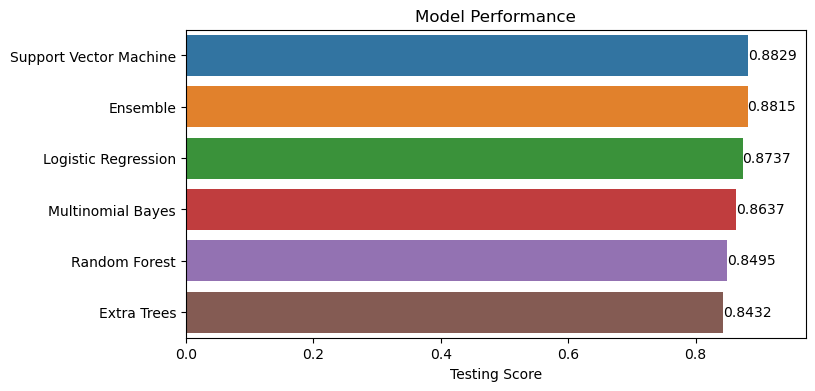

In [77]:
plt.figure(figsize=(8,4))
overall.sort_values(by = 'Test_Score', ascending=False, inplace=True)
sns.barplot(y=overall['Model'], x=overall['Test_Score'], order=overall['Model'])
plt.title('Model Performance')
plt.xlabel('Testing Score')
plt.ylabel(None)


# Add bar values
# source: https://stackoverflow.com/questions/30228069/how-to-display-the-value-on-horizontal-bars, ChatGPT
for i, score in enumerate(overall['Test_Score']):
    plt.text(score, i, f"{score:.4f}", va='center', ha='left')
plt.xlim(0, max(overall['Test_Score']) + .09);

### IV. Final Model

In [93]:
%%time
pipe_logr = Pipeline([
                 ('tvec', TfidfVectorizer(max_df=0.85, max_features=8000, min_df=2)),
                 ('logr', LogisticRegression(C=5.577778, penalty='l2'))
])
pipe_logr.fit(X_train, y_train)

CPU times: total: 438 ms
Wall time: 654 ms


Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.85, max_features=8000, min_df=2)),
                ('logr', LogisticRegression(C=5.577778))])

In [98]:
print(f'~~~~~~~~~~~~ {b1}FINAL MODEL: LOGISTIC REGRESSION{b0} ~~~~~~~~~~~')
print(f'~~~~~~~~~~~~~~~~~~~~~ Train: {round(pipe_logr.score(X_train, y_train),4)} ~~~~~~~~~~~~~~~~~~~~~')
print(f'~~~~~~~~~~~~~~~~~~~~~ Test: {round(pipe_logr.score(X_test, y_test),4)} ~~~~~~~~~~~~~~~~~~~~~~')

~~~~~~~~~~~~ FINAL MODEL: LOGISTIC REGRESSION ~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~ Train: 0.9728 ~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~ Test: 0.8836 ~~~~~~~~~~~~~~~~~~~~~~


In [100]:
%%time
pipe_svc = Pipeline([
                 ('tvec', TfidfVectorizer(max_df=0.8, max_features=7000, min_df=3)),
                 ('svc', SVC(C=1.77779, degree=2))
])
pipe_svc.fit(X_train, y_train)

CPU times: total: 4.94 s
Wall time: 7.83 s


Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.8, max_features=7000, min_df=3)),
                ('svc', SVC(C=1.77779, degree=2))])

In [103]:
print(f'~~~~~~~~~~~~~~ {b1}RUNNER UP: SVM MODEL{b0} ~~~~~~~~~~~~~~')
print(f'~~~~~~~~~~~~~~~~~~ Train: {round(pipe_svc.score(X_train, y_train),4)} ~~~~~~~~~~~~~~~~~')
print(f'~~~~~~~~~~~~~~~~~~ Test: {round(pipe_svc.score(X_test, y_test),4)} ~~~~~~~~~~~~~~~~~~')

~~~~~~~~~~~~~~ RUNNER UP: SVM MODEL ~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~ Train: 0.9979 ~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~ Test: 0.8829 ~~~~~~~~~~~~~~~~~~


##### <span style = 'color:blue'>Both Logistic Regression and SVM performed similarly in terms of their testing accuracy score (88.4% vs. 88.3%). Logistic Regression had a slightly lower precision (91.3% vs. 92.0%), a slightly higher sensitivity (85.2% vs. 84.4%), and a slightly lower specificity (91.6% vs. 92.3%). This means that...
- <span style = 'color:blue'>Of all the posts that our Logistic Regression model predicted would be from the Snowboarding subreddit, 91.3% were classified correctly.
- <span style = 'color:blue'>Of all the posts that were from the Snowboarding subreddit, the Logistic Regression model predicted this outcome correctly 85.2% of the time.
- <span style = 'color:blue'>OF all the posts that were from the Skiing subreddit, the Logistic Regression model predicted this outcome correctly 91.6% of the time.
- <span style = 'color:blue'>The Logistic Regression is slightly more likely to commit Type I errors than the SVM, that is, it is more likely to mis-classify Skiers as Snowboarders (e.g., incorrectly predict the positive class).
- <span style = 'color:blue'>The Logistic Regression is slightly less likely to commit Type II errors than the SVM, that is, it is less likely to mis-classify Snowboarders as Skiers (e.g., incorrectly predict the negative class).

In [78]:
#pipe_logr = Pipeline([
                 #('tvec', TfidfVectorizer(max_df=0.85, max_features=7000, min_df=2, stop_words='english')),
                 #('logr', LogisticRegression(penalty='l2', C=2.261))
#])
#pipe_logr.fit(X_train, y_train)

#print('Train:', round(pipe_logr.score(X_train, y_train),4))
#print('Test:', round(pipe_logr.score(X_test, y_test),4))

In [79]:
#%%time
#pipe_logr2 = Pipeline([
                 #('tvec', TfidfVectorizer(max_df=0.85, max_features=7000, min_df=2)),
                 #('logr', LogisticRegression(penalty='l2', C=4.472))
#])
#pipe_logr2.fit(X_train, y_train)

#print('Train:', round(pipe_logr2.score(X_train, y_train),4))
#print('Test:', round(pipe_logr2.score(X_test, y_test),4))

In [80]:
#SVM: Best Params: {'svc__C': 1.5, 'svc__degree': 2, 'vec': TfidfVectorizer(max_df=0.8, max_features=7000, min_df=3), 'vec__max_df': 0.8, 'vec__max_features': 7000, 'vec__min_df': 3, 'vec__stop_words': None} -->0.8829
#Best Params: {'svc__C': 1.7777888888888889, 'svc__degree': 2, 'vec': TfidfVectorizer(max_df=0.8, max_features=7000, min_df=3), 'vec__max_df': 0.8, 'vec__max_features': 7000, 'vec__min_df': 3, 'vec__stop_words': None}--0.877

In [81]:
#LOGISTIC RANDOMIZED: Best Params: {'vec__stop_words': None, 'vec__min_df': 2, 'vec__max_features': 7000, 'vec__max_df': 0.95, 'vec': TfidfVectorizer(max_df=0.95, max_features=8000, min_df=2), 'logr__penalty': 'l2', 'logr__C': 4.472222222222221}

In [82]:
# Define hyperparameters
#pgrid_logr =[
    #{
    #'vec': [CountVectorizer()],
    #'vec__stop_words': [None, 'english'],
    #'vec__max_features': [7000, 8000], 
    #'vec__min_df': [2, 3],
    #'vec__max_df': [0.85], #tested 0.8, 0.95 as well
    #'vec__preprocessor': [None, lemmatize_txt, stem_txt],
    #'logr__C': np.linspace(.05,10.0,10),
    #'logr__penalty': ['l2'] #tested l1, l2 was more optimal
    #},
    #{
    #'vec': [TfidfVectorizer()],
    #'vec__stop_words': [None, 'english'],
    #'vec__max_features': [7000, 8000], 
    #'vec__min_df': [2, 3],
    #'vec__max_df': [0.85],
    #'vec__preprocessor': [None, lemmatize_txt, stem_txt],
    #'logr__C': np.linspace(.05,10.0,10),
    #'logr__penalty': ['l2']
    #}
#]

In [83]:
#%%time

# Test RandomizedSearch for comparison in timing and outcome
#rs_log = RandomizedSearchCV(pipe_log, pgrid_logr, cv=5, n_iter=10, n_jobs=10)
#rs_log.fit(X_train, y_train)

In [84]:
#print(f'--------- {b1}Logistic Regression w/ GridSearch{b0} ---------') # source: https://stackoverflow.com/questions/8924173/how-can-i-print-bold-text-in-python
#print(f'------------------- Train: {round(rs_log.score(X_train, y_train),4)} -------------------')
#print(f'------------------- Test: {round(rs_log.score(X_test, y_test),4)} --------------------')
#print('Best Params:', rs_log.best_params_)